import libraries

In [313]:
import tensorflow as tf
from tensorflow.keras import layers as keras_layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, GlobalAveragePooling2D, Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import glob
import random

read and load images function

In [314]:
image_size = (224, 224)
def load_process_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, image_size)
    return img

In [315]:
load_image = load_process_image("./dataset/valid/images/Frame_108.jpg")

load and process labels function

In [316]:
def load_process_label(label_path):
    with open(label_path, "r") as file:
        lines = file.readlines()

        label_values = [list(map(float, label.strip().split())) for label in lines]
        label_array = np.array(label_values).flatten()

        return label_array[1:]

In [317]:
load_label = load_process_label("./dataset/valid/labels/Frame_108.txt")

draw the bounding box of images function

In [318]:
def draw_bounding_box(img, label, color=(255,0,0)):
    class_id = int(label[0])
    x_center, y_center, width, height = map(float, label)

    img_w, img_h = image_size
    x_center, y_center = int(x_center * img_w), int(y_center * img_h)
    width, height = int(width * img_w), int(height * img_h)

    x1, y1 = x_center - width // 2, y_center - height // 2
    x2, y2 = x_center + width // 2, y_center + height // 2

    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

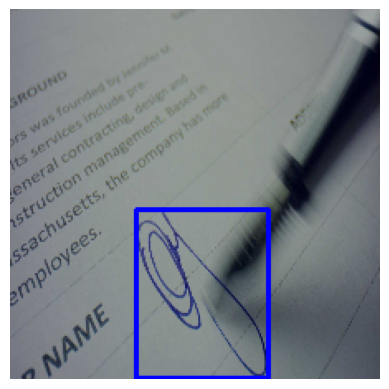

In [319]:
image_bounding_box = draw_bounding_box(load_image, load_label)

plt.imshow(cv2.cvtColor(image_bounding_box, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

IoU loss function

In [ ]:
def iou_loss(y_true, y_pred):
    cx_true, cy_true, w_true, h_true = tf.split(y_true, 4, axis=-1)
    cx_pred, cy_pred, w_pred, h_pred = tf.split(y_pred, 4, axis=-1)

    x1_true = cx_true - w_true / 2.0
    y1_true = cy_true - h_true / 2.0
    x2_true = cx_true + w_true / 2.0
    y2_true = cy_true + h_true / 2.0

    x1_pred = cx_pred - w_pred / 2.0
    y1_pred = cy_pred - h_pred / 2.0
    x2_pred = cx_pred + w_pred / 2.0
    y2_pred = cy_pred + h_pred / 2.0

    x1_inter = tf.maximum(x1_true, x1_pred)
    y1_inter = tf.maximum(y1_true, y1_pred)
    x2_inter = tf.minimum(x2_true, x2_pred)
    y2_inter = tf.minimum(y2_true, y2_pred)

    inter_area = tf.maximum(0.0, x2_inter - x1_inter) * tf.maximum(0.0, y2_inter - y1_inter)

    true_area = (x2_true - x1_true) * (y2_true - y1_true)
    pred_area = (x2_pred - x1_pred) * (y2_pred - y1_pred)
    union_area = true_area + pred_area - inter_area


    iou = inter_area / (union_area + 1e-6)

    # IoU loss = 1 - IoU
    return 1.0 - tf.squeeze(iou, axis=-1)

define train and validation dataset variables

In [321]:
images_train_dir = "./dataset/train/images"
labels_train_dir = "./dataset/train/labels"

images_valid_dir = "./dataset/valid/images"
labels_valid_dir = "./dataset/valid/labels"

set image and label pairs

In [322]:
def get_image_labels_pairs(image_dir, label_dir):
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

    image_label_pairs = []
    for img_path in image_paths:
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, base_name + ".txt")

        if not os.path.exists(label_path):
            print(f"Warning: Label file not found for {base_name}")
            continue

        image_label_pairs.append((
            load_process_image(img_path),
            load_process_label(label_path)
        ))

    return image_label_pairs


In [323]:
train_data = get_image_labels_pairs(
    images_train_dir,
    labels_train_dir
)

In [324]:
len(train_data)

143

In [325]:
val_data = get_image_labels_pairs(
    images_valid_dir,
    labels_valid_dir
)

In [326]:
len(val_data)

35

split the train images data

train data

In [327]:
train_images, train_labels = zip(*train_data)

In [328]:
train_images = np.array(train_images).astype(np.float32) / 255.0
train_labels = np.array(train_labels).astype(np.float32)

In [329]:
len(train_images), len(train_labels)

(143, 143)

validation data

In [330]:
val_images, val_labels = zip(*val_data)

In [331]:
val_images = np.array(val_images).astype(np.float32) / 255.0
val_labels = np.array(val_labels).astype(np.float32)

In [332]:
len(val_images), len(val_labels)

(35, 35)

visualize random data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


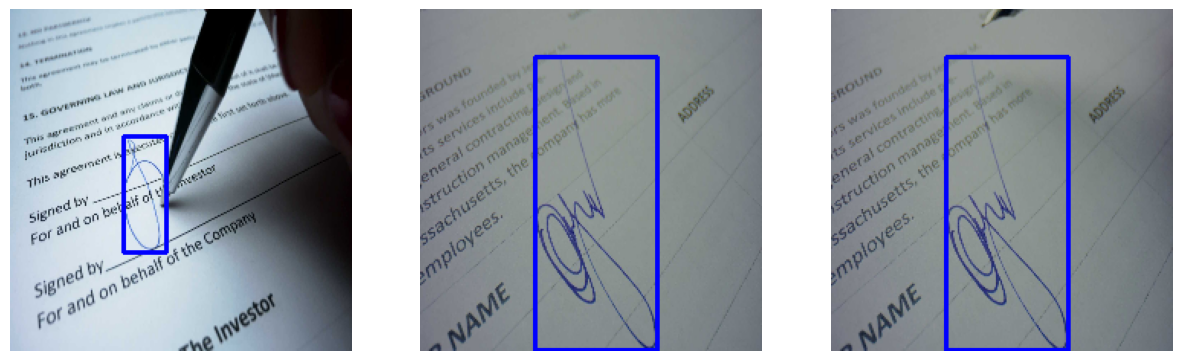

In [333]:
def plot_random_image(images, labels, show = 5, range_len = 10):
  random_indices = random.sample(range(0, range_len), show)
  fig, axes = plt.subplots(1, show, figsize=(15, 5))

  for i, idx in enumerate(random_indices):
      random_draw_ground = draw_bounding_box(images[idx], labels[idx])

      axes[i].imshow(cv2.cvtColor(random_draw_ground, cv2.COLOR_BGR2RGB))
      axes[i].axis("off")

  plt.show()

plot_random_image(train_images, train_labels, show = 3, range_len=142)

base model

In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, 3, padding="same")(input_layer)
x = Activation("relu")(x)
x = MaxPooling2D()(x)

x = Conv2D(64, 3, padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x)

x = Conv2D(128, 3, padding="same")(x)
x = Activation("relu")(x)
x = MaxPooling2D()(x)

x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)

bbox_output = Dense(4, activation="linear", name="bbox")(x)

model = Model(inputs=input_layer, outputs=bbox_output)

In [335]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_31 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_32 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_10     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bbox (Dense)                    │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,276 (430.77 KB)

 Trainable params: 110,276 (430.77 KB)

 Non-trainable params: 0 (0.00 B)

In [336]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[iou_loss]
)

In [337]:
history_model_1 = model.fit(
    train_images,
    train_labels,
    epochs=30,
    batch_size=4
)

Epoch 1/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - iou_loss: 0.9688 - loss: 0.1575
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_loss: 0.9562 - loss: 0.1149
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - iou_loss: 0.8693 - loss: 0.0460
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss: 0.8386 - loss: 0.0370
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss: 0.7913 - loss: 0.0299
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss: 0.7928 - loss: 0.0297
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - iou_loss: 0.7362 - loss: 0.0233
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - iou_loss: 0.7424 - loss: 0.0216
Epoch 9/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss: 0.7340 - loss: 0.0199
Epoch 10/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss: 0.6558 - loss: 0.0149
Epoch 11/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - iou_loss: 0.6865 - loss: 0.0163
Epoch 12/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - iou_loss:

evaluate the model

In [338]:
model.evaluate(val_images, val_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - iou_loss: 0.2550 - loss: 0.0015 


[0.0014972580829635262, 0.25679031014442444]

In [339]:
model_1_preds_probs = model.predict(val_images)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


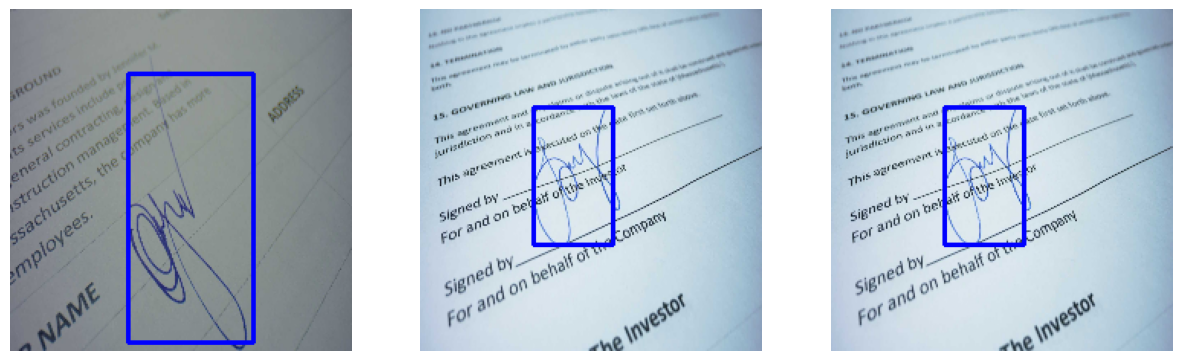

In [340]:
plot_random_image(val_images, model_1_preds_probs, show=3, range_len=30)

In [341]:
model.save("cnn_signature_model_v1.keras")